# Mingxin Liu

# Assignment 4




# Exercise one correlation


### Exploring with two different cross-correlation methods

Usually we would compute the intensity comparison of the images to detect their optic flow. However, there is another way to do so and is to perform correlation. Correlation process is to maximize the product of the two aligned images. Therefore, we are going to introduce a second step where we normalize the cross-correlation in order to achieve the mean images. 

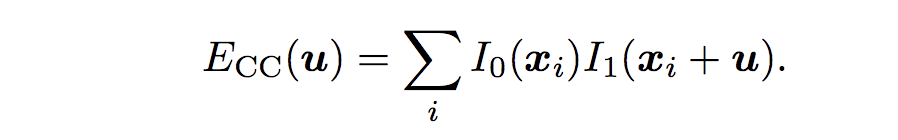

### gradient cross-correlation

- first we consider the case of finding the estimate motion by the gradient cross-correlation method, then we weill explore with two other correlation methods. 

- $$ { \frac{\partial I}{\partial x}} u + { \frac{\partial I}{\partial y}} v + { \frac{\partial I}{\partial t}}= 0,$$
- here we are computing the gradient at a point.
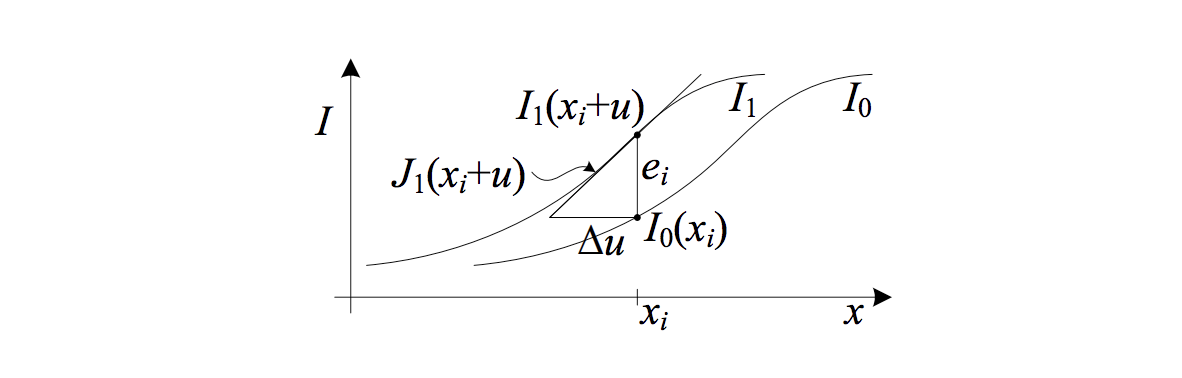
(x,y) is the gradient point we are taking in consideration and (u,v) being the velocity change of this selected point. 

\begin{aligned}
I_x &= \frac{I(x+1, y) - I(x-1, y)}{2} \\
I_y &= \frac{I(x, y+1) - I(x, y-1)}{2} \\ 
I_t &= \frac{I(x, t+1) - I(x, t-1)}{2}
\end{aligned}

Then we computer the gradient of this point by computing the the derivative of the moving pixel on the image.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def plotflow(I, X, Y, U, V, scale=1, threshold=-1):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    if threshold > 0:
        mask = np.abs(U + 1j*V) > threshold
        X = X[mask]
        Y = Y[mask]
        U = U[mask]
        V = V[mask]
        
    ax.imshow(I, cmap='gray')
    ax.quiver(X, Y, U*scale, V*scale, color='red', angles='xy', scale_units='xy', scale=1)
    ax.set_aspect('equal')
    plt.show()

seq1 = {'I1': io.imread('image/seq1/frame1.png', as_grey=True), 
        'I2': io.imread('image/seq1/frame3.png', as_grey=True),
        'U' : np.loadtxt('flow/seq1/flow3.u', dtype='double', delimiter=','),
        'V' : np.loadtxt('flow/seq1/flow3.v', dtype='double', delimiter=',')}

rubic = {'I1':io.imread('rubic/rubic.0.png', as_grey=True), 
         'I2':io.imread('rubic/rubic.5.png', as_grey=True)}

sphere= {'I1': io.imread('sphere/sphere.1.png', as_grey=True), 
         'I2': io.imread('sphere/sphere.3.png', as_grey=True)}


I = np.random.rand(128, 128)
synth = {'I1': I[0:100, 0:100], 
         'I2': I[2:102, 2:102]}

Here I kept the original code for the data input.

In [9]:
def gradient_xyt(I1, I2, x, y):
    h, w = I1.shape
    x = int(x)
    y = int(y)
    
    Ix = (x>0 and x< (w-1) and y>=0 and y<h ) and (I1[y, x+1] - I1[y, x-1])/2 or 0
    Iy = (x>=0 and x<w and y>0 and y< (h-1) ) and (I1[y+1, x] - I1[y-1, x])/2 or 0
    It = (x>=0 and x<w and y>=0 and y<h) and I2[y,x] - I1[y,x] or 0
    return (Ix, Iy, It)

In [10]:
def getAb(I1, I2, x, y, n):
    A = np.zeros((n*n, 2))
    b = np.zeros(n*n)
    
    # compute the relative positions of pixels in a window
    offset = np.arange(0, n) - np.floor(n/2); 
    dx, dy = np.meshgrid(offset, offset);
    dx = dx.reshape(n*n, 1);
    dy = dy.reshape(n*n, 1);
    
    # compute the elements of A and b
    for i in range(0, n*n):
        Ix, Iy, It = gradient_xyt(I1, I2, x+dx[i], y+dy[i])
        A[i, 0] = Ix 
        A[i, 1] = Iy
        b[i] = -It
        
    return (A, b)

In [11]:
##  flow->motion
def estimate_flow_at_xy(I1, I2, x, y, n):
    A, b = getAb(I1, I2, x, y, n)
 
    # least square 
    # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html  
    result = np.linalg.lstsq(np.matmul(A.T, A), np.matmul(A.T, b))
    # result = np.linalg.lstsq(A, b)
    v = result[0]
    return v

In [13]:
def estimate_flow(I1, I2, gridX, gridY, n):
    H, W = gridX.shape # the height and width of output 
    U = np.zeros((H, W))
    V = np.zeros((H, W))
    
    # iterate over the grid
    for i in range(0, H):
        for j in range(0, W):
            v =  estimate_flow_at_xy(I1, I2,gridX[i, j], gridY[i, j], n)
            U[i, j] = v[0]
            V[i, j] = v[1]
    return (U, V)

In [26]:
def test_estimate_flow(seq):
    H, W = seq['I1'].shape
    gridsz = 9
    wsz  = 21
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U, V = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    plotflow(seq["I1"], gridX, gridY, U, V, 3, 0.3)



In [19]:
from scipy.signal import correlate2d

def estimate_mv_xy(I1, I2, x, y, n, u0, v0):
    h, w = I1.shape
    x = int(x)
    y = int(y)
    n2 = int(np.floor(n/2))
    # extract patch in I1 at x, y
    i11 = (y-n2)   > 0 and y-n2 or 0
    i12 = (y+n2+1) < h and y+n2+1 or h
    j11 = (x-n2)   > 0 and x-n2 or 0
    j12 = (x+n2+1) < w and x+n2+1 or w 
    patch = I1[i11:i12, j11:j12]
    
    # extract the search region in I2
    i21 = y-n2-v0   > 0 and y-n2-v0 or 0
    i22 = y+n2+1+v0 < h and y+n2+1+v0 or h
    j21 = x-n2-u0   > 0 and x-n2-u0 or 0
    j22 = x+n2+1+u0 < w and x+n2+1+u0 or w 
    region = I2[i21:i22, j21:j22]
    
    # correlation
    response = correlate2d(region, patch, 'valid')
    i, j = np.unravel_index(response.argmax(), response.shape)
    
    # caculate mv
    u = j21-j11+j
    v = i21-i11+i
    return (u, v)

In [20]:
def estimate_mv(I1, I2, gridX, gridY, n, u0, v0):
    H, W = gridX.shape # the height and width of output 
    U = np.zeros((H, W))
    V = np.zeros((H, W))
    
    # iterate over the grid
    for i in range(0, H):
        for j in range(0, W):
            u, v =  estimate_mv_xy(I1, I2,gridX[i, j], gridY[i, j], n, u0, v0)
            U[i, j] = u
            V[i, j] = v
            
    return (U, V)

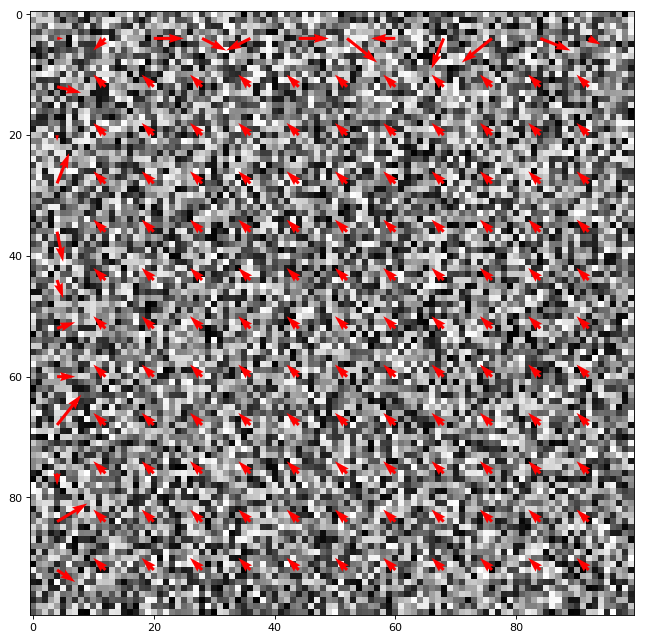

In [46]:
def test_estimate_mv(seq):
    H, W = seq['I1'].shape
    gridsz = 8
    wsz  = 11
    u0 = 5
    v0 = 5
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U, V = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0)
    plotflow(seq["I1"], gridX, gridY, U, V, 1, 0.3)

    
test_estimate_mv(synth)

In [44]:
def comp(seq):
    H, W = seq['I1'].shape
    gridsz = 7
    wsz  = 11
    u0 = 2
    v0 = 2
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U1, V1 = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    U2, V2 = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0) 
    # U0 = U[x, y];
    # V0 = V[x, y];
    # plotflow(seq["I1"], gridX, gridY, U1, V1, 1, 0.3)
    plotflow(seq["I1"], gridX, gridY, U1, V1, 1, 0.3)
    plotflow(seq["I1"], gridX, gridY, U2, V2, 1, 0.3)
    

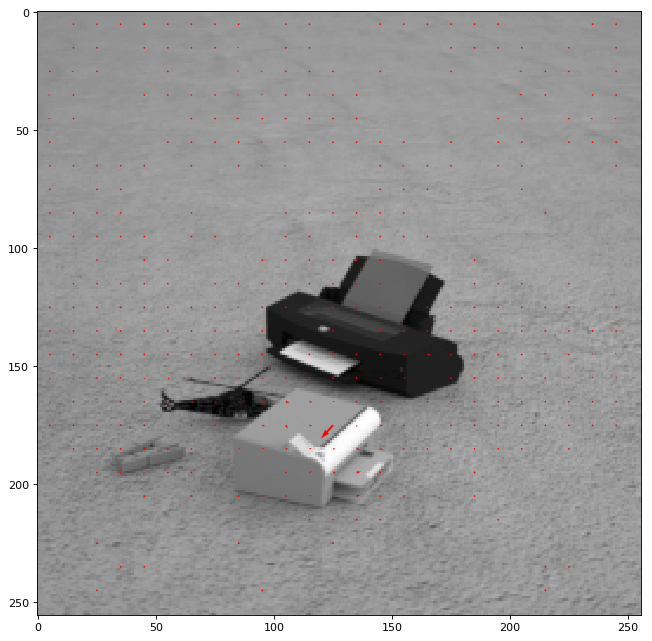

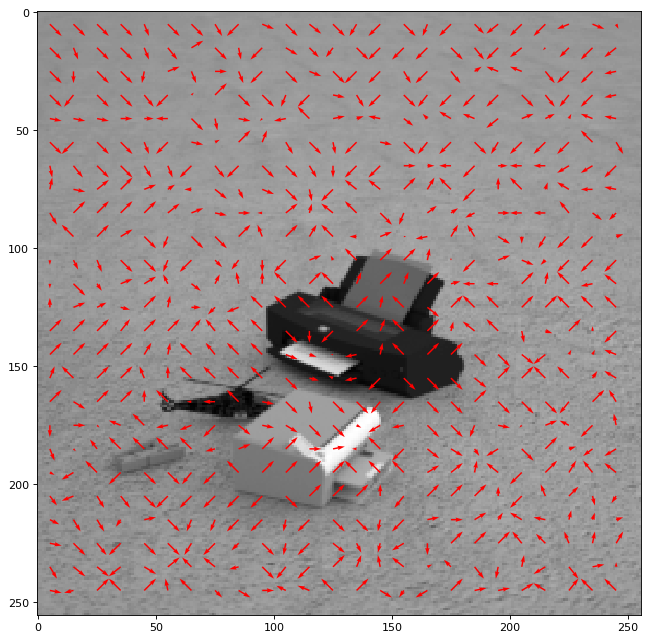

In [27]:
comp(seq1)

 ## Exploration
 ![](eq1.png )
With the normalized graph, the mean images of the corresponding patches and N is the number in total. The normalized graph for cross-correlation will always has the graph lies between -1 and 1. Then there is actually two ways to perform correlation. 

- windowed correlation

![](eq3.png )

- phase correlation
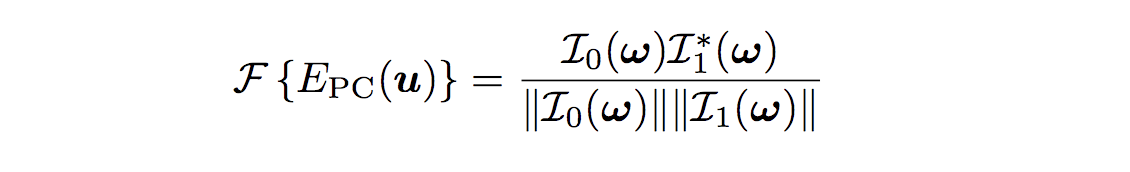




### windowed correlation

- The windowed correlation algorithm unfortunately only works with images with the same sizes. In another word, the Fourier convolution applies when the summation over xi is performed over every single pixel in both images with a the image shifting accessing the pixels outside of the original boundaries. 

- This case, we replace the cross-correlation function with windowed cross-correlation function. 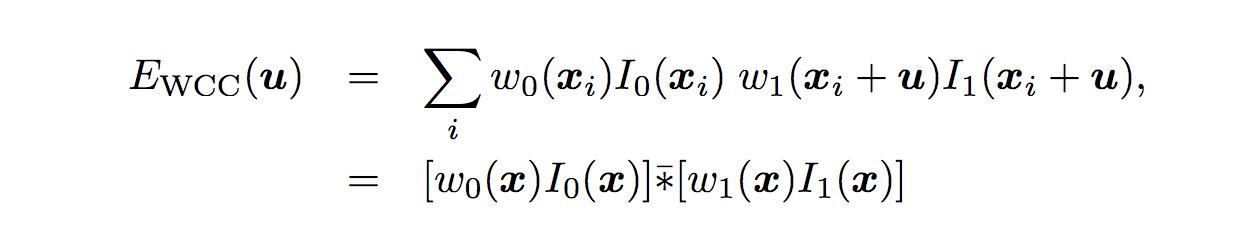

- Here the weighting functions w0 and w1 are zero outside the valid ranges of the images and will be padded with null with the boundaries outside of the original image. 


### phase correlation

- Another common correlation method used for motion estimation is phase correlation. Then in order to shift the image in the case of noiseless signals we can obtain an inverse Fourier transform and its 
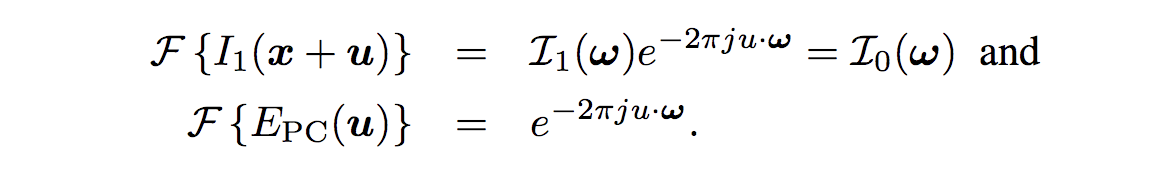
- Thus, the ideal output of the phase correlation is going to be an impulse at the correct value of u. Phase correlation can be performing better than regular correlation. 




In [30]:
#Windowed correlation
def windowed(seq):
    xi = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);

    for i in range(0, W):
        result = wo(i) * I0(i) * w1(xo(i) + u) * I0(i+1) 
    
    U1, V1 = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    U2, V2 = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0) 
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U1, V1 = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    U2, V2 = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0) 
    # U0 = U[x, y];
    # V0 = V[x, y];
    # plotflow(seq["I1"], gridX, gridY, U1, V1, 1, 0.3)
    plotflow(seq["I1"], gridX, gridY, U1, V1, 1, 0.3)
    plotflow(seq["I1"], gridX, gridY, U2, V2, 1, 0.3)


#phase correlation

def phase(seq):
    
    xi = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
    
    re = fft(I0(x))
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2);
    gridX, gridY = np.meshgrid(x,y);
    U1, V1 = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    U2, V2 = estimate_mv(seq["I1"], seq["I2"], gridX, gridY, wsz, u0, v0) 
    # U0 = U[x, y];
    # V0 = V[x, y];
    # plotflow(seq["I1"], gridX, gridY, U1, V1, 1, 0.3)
    plotflow(seq["I1"], gridX, gridY, U1, V1, 1, 0.3)
    plotflow(seq["I1"], gridX, gridY, U2, V2, 1, 0.3)




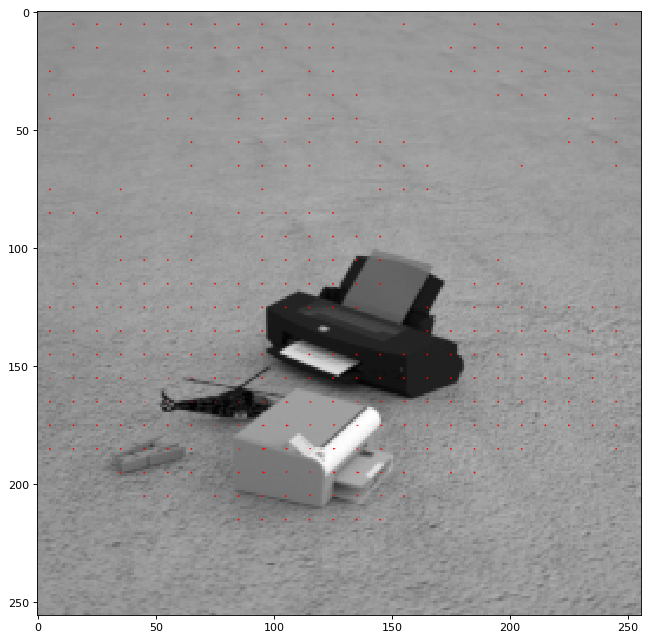

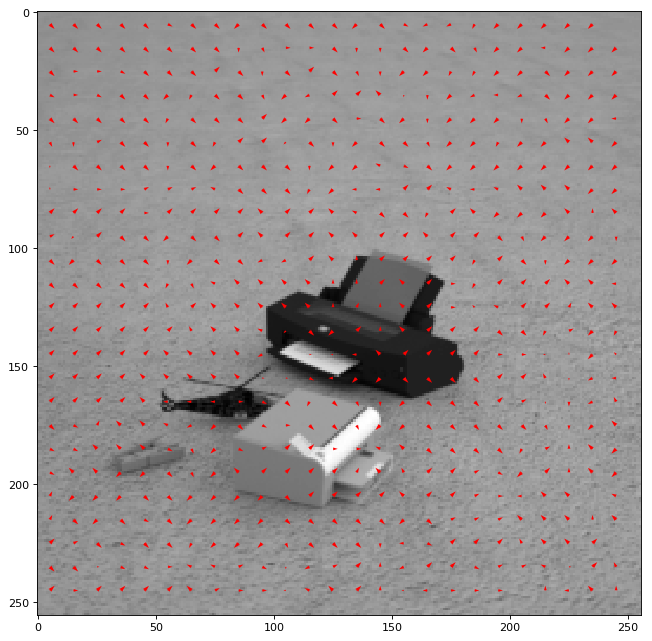

In [43]:
windowed(seq1)

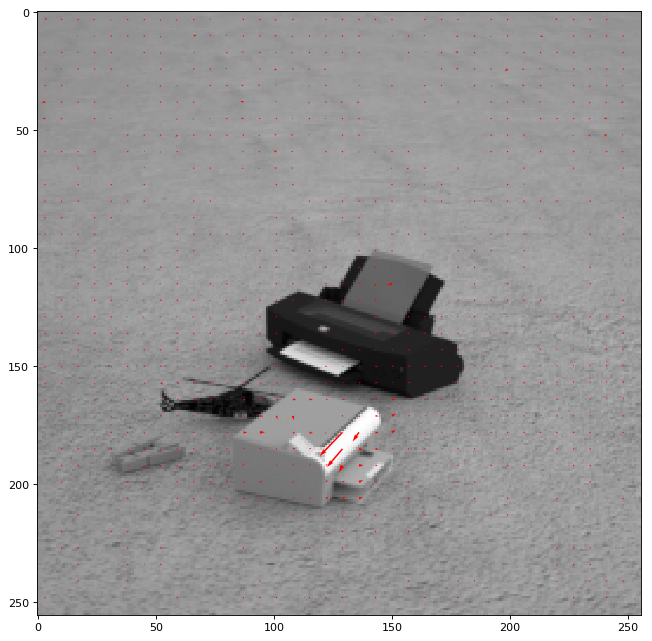

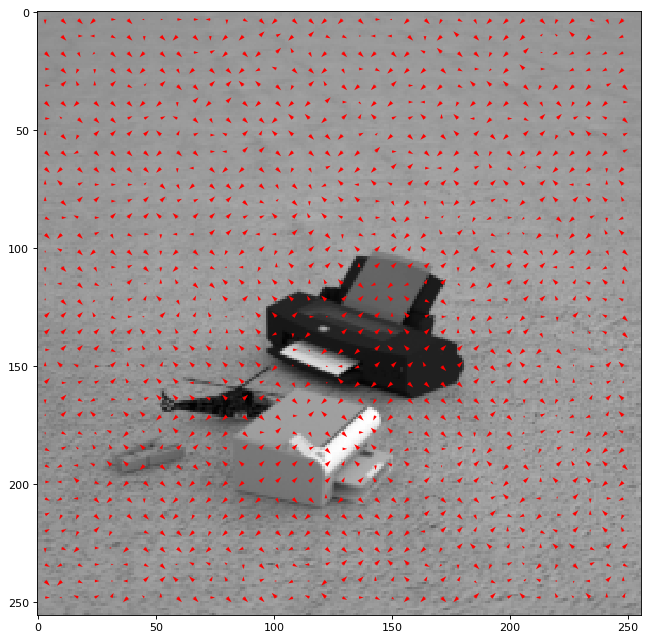

In [45]:
phase(seq1)

## Conclusion

Comparing wiht the windowed correlation, phase correlation shows a better motion detection from the meshgrid. The movement of the white printer can be clearly seen from the phase correlation result. 